In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np


In [38]:

df = pd.read_csv('re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

In [39]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

In [40]:
df.head()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-01 01:00:00,37.76,48.48,95.59,111.11,43.5,3.351
2013-01-01 02:00:00,30.01,48.30,95.59,111.11,43.5,3.351
2013-01-01 03:00:00,21.98,46.40,95.59,111.11,43.5,3.351
2013-01-01 04:00:00,18.06,45.40,95.59,111.11,43.5,3.351
2013-01-01 05:00:00,18.06,44.44,95.59,111.11,43.5,3.351


In [41]:
df_lagged = table2lags(df, 168, 24)

In [42]:
df_lagged.columns

Index(['GBP/mWh_24', 'temperature_24', 'coal Price_24', 'oil Price_24',
       'uranium Price_24', 'natural gas Price_24', 'GBP/mWh_25',
       'temperature_25', 'coal Price_25', 'oil Price_25',
       ...
       'coal Price_167', 'oil Price_167', 'uranium Price_167',
       'natural gas Price_167', 'GBP/mWh_168', 'temperature_168',
       'coal Price_168', 'oil Price_168', 'uranium Price_168',
       'natural gas Price_168'],
      dtype='object', length=870)

In [43]:
df_lagged.shape

(61326, 870)

In [44]:
x_train = df_lagged[168:43800]
x_valid = df_lagged[43800:52560]
x_test = df_lagged[52560:]

In [105]:
y_train = df['GBP/mWh'][168:43800]
y_valid = df['GBP/mWh'][43800:52560]
y_test = df['GBP/mWh'][52560:]

In [46]:
x_test.head()

,GBP/mWh_24,temperature_24,coal Price_24,oil Price_24,uranium Price_24,natural gas Price_24,GBP/mWh_25,temperature_25,coal Price_25,oil Price_25,...,coal Price_167,oil Price_167,uranium Price_167,natural gas Price_167,GBP/mWh_168,temperature_168,coal Price_168,oil Price_168,uranium Price_168,natural gas Price_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 14:00:00,60.96,51.68,98.35,52.2,28.7,3.303,57.40,50.46,98.35,52.2,...,98.75,53.82,28.6,3.816,57.80,46.43,98.75,53.82,28.6,3.816
2018-12-31 15:00:00,53.80,51.75,98.35,52.2,28.7,3.303,60.96,51.68,98.35,52.2,...,98.75,53.82,28.6,3.816,67.95,46.30,98.75,53.82,28.6,3.816
2018-12-31 16:00:00,78.00,50.05,98.35,52.2,28.7,3.303,53.80,51.75,98.35,52.2,...,98.75,53.82,28.6,3.816,86.00,43.20,98.75,53.82,28.6,3.816
2018-12-31 17:00:00,92.00,50.33,98.35,52.2,28.7,3.303,78.00,50.05,98.35,52.2,...,98.75,53.82,28.6,3.816,99.00,40.75,98.75,53.82,28.6,3.816
2018-12-31 18:00:00,78.00,50.46,98.35,52.2,28.7,3.303,92.00,50.33,98.35,52.2,...,98.75,53.82,28.6,3.816,80.00,38.67,98.75,53.82,28.6,3.816


In [47]:
rf = RandomForestRegressor(n_estimators=10, max_features=2,
    criterion='mae',
    max_depth=1)

    
rf.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
y_test = pd.DataFrame(y_test)

In [50]:
y_pred = rf.predict(x_test)

In [53]:
y_test['predictions'] = y_pred

In [65]:
y_test['difference'] = np.abs(y_test['GBP/mWh'] - y_test['predictions'])
y_test['% error'] = (y_test['difference']/y_test['GBP/mWh'])*100
np.mean(y_test['% error'])

In [72]:
y_test['% error'] = (y_test['difference']/y_test['GBP/mWh'])*100

In [73]:
y_test

,GBP/mWh,predictions,difference,% error
datetime,,,,
2018-12-31 14:00:00,54.00,42.4215,11.5785,21.441667
2018-12-31 15:00:00,58.77,42.4215,16.3485,27.817764
2018-12-31 16:00:00,79.00,42.4215,36.5785,46.301899
2018-12-31 17:00:00,90.00,43.1405,46.8595,52.066111
2018-12-31 18:00:00,76.97,43.1405,33.8295,43.951540
...,...,...,...,...
2019-12-31 17:00:00,55.10,36.9240,18.1760,32.987296
2019-12-31 18:00:00,45.60,36.9240,8.6760,19.026316
2019-12-31 19:00:00,39.07,36.9240,2.1460,5.492705


In [74]:
np.mean(y_test['% error'])

19.730314364966624

In [69]:
y_test.drop(y_test.loc[y_test['% error'] > 2000].index, inplace = True)

In [70]:
np.mean(np.abs(y_test['GBP/mWh'] - y_test['predictions']) * 100)

812.9533337138944

In [75]:
features = 

SyntaxError: invalid syntax (<ipython-input-75-ff907f8f7b8c>, line 1)

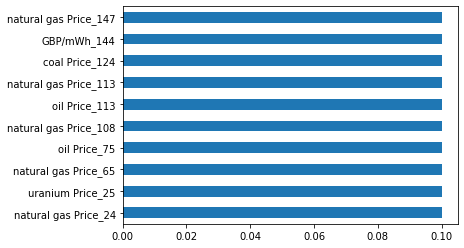

In [76]:
feat_importances = pd.Series(rf.feature_importances_, index=df_lagged.columns)
feat_importances.nlargest(10).plot(kind='barh')


In [81]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
gridsearch = {'bootstrap': [True],
     'max_depth': [10, 250],
     'min_samples_leaf': [2, 5],
     'n_estimators': [100, 200]}
# print(gridsearch)
# {'bootstrap': [True],
#  'max_depth': [10, 50, 250,1000],
#  'max_features': [2, 'sqrt'],
#  'min_samples_leaf': [1, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 1000, 2000]}

In [82]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch = GridSearchCV(
 estimator = rf, 
 param_grid = gridsearch, 
 cv = 4,
 verbose=2, 
 n_jobs = 1)

In [ ]:
rf_GridSearch.fit(x_train, y_train)

In [ ]:
print(rf_GridSearch.best_score_)
print(rf_GridSearch.best_params_)

In [86]:
rf = RandomForestRegressor(n_estimators=250, max_features=5,
    criterion='mae',
    max_depth=15)

    
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=15,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [88]:
prediciton = rf.predict(x_test)

In [91]:
prediciton = pd.DataFrame(prediciton)

prediciton.to_csv('randomforestprediction')

In [93]:
len(prediciton)

8766

In [97]:
len(x_test)

8766

In [104]:
x_test.isna().sum()

GBP/mWh_24               0
temperature_24           0
coal Price_24            0
oil Price_24             0
uranium Price_24         0
                        ..
temperature_168          0
coal Price_168           0
oil Price_168            0
uranium Price_168        0
natural gas Price_168    0
Length: 870, dtype: int64

In [109]:
y_test

datetime
2018-12-31 14:00:00    54.00
2018-12-31 15:00:00    58.77
2018-12-31 16:00:00    79.00
2018-12-31 17:00:00    90.00
2018-12-31 18:00:00    76.97
                       ...  
2019-12-31 17:00:00    55.10
2019-12-31 18:00:00    45.60
2019-12-31 19:00:00    39.07
2019-12-31 20:00:00    37.71
2019-12-31 21:00:00    34.22
Name: GBP/mWh, Length: 8766, dtype: float64

In [110]:
prediciton['actual'] = y_test.values

In [114]:
prediciton

,prediction,actual
0,62.54628,54.00
1,60.94958,58.77
2,62.34566,79.00
3,70.90116,90.00
4,69.32762,76.97
...,...,...
8761,47.12780,55.10
8762,47.12176,45.60
8763,44.51508,39.07
8764,42.15642,37.71


In [113]:
prediciton.rename(columns = {0:'prediction'}, inplace = True)

In [148]:
prediciton['difference'] = np.abs(prediciton['actual'] - prediciton['prediction'])
prediciton['% error'] = ((prediciton['difference'] + 0.5) /(prediciton['actual'] + 0.5))*100
# np.mean(prediciton['% error'])

In [149]:
prediciton['% error'].mean()

23.115789503280187

In [125]:
from numpy import inf

In [132]:
prediciton.loc[prediciton['% error'] == 36798.27999999999]

,prediction,actual,difference,% error
8218,36.69828,0.0,36.69828,36798.28


In [141]:

mape = 100 * (prediciton['difference'] / prediciton['actual'])
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
100 - accuracy

109.35813725358307

In [142]:
prediciton['% error'] = mape

In [153]:
np.mean(mape[np.isfinite(mape)])

109.35813725358307

In [155]:
mape

0       15.826444
1        3.708661
2       21.081443
3       21.220933
4        9.929037
          ...    
8761    14.468603
8762     3.337193
8763    13.936729
8764    11.791090
8765    18.607130
Length: 8766, dtype: float64

In [156]:
mape[np.isfinite(mape)].mean()

109.35813725358307